# Análisis Exploratorio de los datos de Trocafone



## Configuracion inicial

In [150]:
#Importo librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import ScalarFormatter

In [79]:
%matplotlib inline
plt.style.use('default')
sns.set()

In [80]:
#Funciones auxiliares
def mostrar_porcentaje_barplot(ax):
    suma = 0
    for p in ax.patches:
        suma += p.get_height()
    for p in ax.patches:
        ax.annotate(str(np.round(100 *(p.get_height() / suma),decimals=2)) + "%", (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
def mostrar_valores_barplot(ax):
    for p in ax.patches:
        ax.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

In [81]:
#Cargo el DataFrame
df = pd.read_csv('events.csv', low_memory = False, parse_dates = ['timestamp'], infer_datetime_format = True,
                    dtype = {'event': 'category','condition': 'category','storage': 'category', 'color': 'category', 'staticpage': 'category', 'campaign_source': 'category', 'search_engine': 'category', 'channel': 'category', 'new_vs_returning': 'category', 'region': 'category', 'country': 'category', 'device_type': 'category'})
df.head()

,timestamp,event,person,url,sku,model,condition,storage,color,skus,...,search_engine,channel,new_vs_returning,city,region,country,device_type,screen_resolution,operating_system_version,browser_version
0,2018-05-31 23:38:05,ad campaign hit,0004b0a2,/comprar/iphone/iphone-5s,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-05-31 23:38:05,visited site,0004b0a2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Paid,New,Camaragibe,Pernambuco,Brazil,Smartphone,360x640,Android 6,Chrome Mobile 39
2,2018-05-31 23:38:09,viewed product,0004b0a2,NaN,2694.0,iPhone 5s,Bom,32GB,Cinza espacial,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-05-31 23:38:40,checkout,0004b0a2,NaN,2694.0,iPhone 5s,Bom,32GB,Cinza espacial,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-05-29 13:29:25,viewed product,0006a21a,NaN,15338.0,Samsung Galaxy S8,Bom,64GB,Dourado,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Chequeos de integridad y calidad de los datos


In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1011288 entries, 0 to 1011287
Data columns (total 23 columns):
timestamp                   1011288 non-null datetime64[ns]
event                       1011288 non-null category
person                      1011288 non-null object
url                         82756 non-null object
sku                         563838 non-null object
model                       564284 non-null object
condition                   563836 non-null category
storage                     563836 non-null category
color                       563836 non-null category
skus                        221699 non-null object
search_term                 48967 non-null object
staticpage                  3598 non-null category
campaign_source             82796 non-null category
search_engine               50957 non-null category
channel                     87378 non-null category
new_vs_returning            87378 non-null category
city                        87378 non-null object


Como podemos ver, todas las filas especifican 'timestamp', 'event' y 'person'

### Analizamos los valores que pueden tomar las columnas categoricas

In [83]:
valores = df['condition'].unique()
for valor in valores:
    print(valor, end = ', ')

nan, Bom, Muito Bom, Excelente, Bom - Sem Touch ID, Novo, 

In [84]:
valores = df['storage'].unique()
for valor in valores:
    print(valor, end = ', ')

nan, 32GB, 64GB, 256GB, 16GB, 8GB, 128GB, 4GB, 512MB, 

In [85]:
valores = df['channel'].unique()
for valor in valores:
    print(valor, end = ', ')

nan, Paid, Organic, Direct, Social, Referral, Email, Unknown, 

In [86]:
valores = df['staticpage'].unique()
for valor in valores:
    print(valor, end = ', ')

nan, how-to-buy, trust-trocafone, Quiosks, FaqEcommerce, AboutUs, Conditions, TermsAndConditionsEcommerce, CustomerService, galaxy-s8, how-to-sell, TermsAndConditionsReturnEcommerce, club-trocafone, black_friday, PrivacyEcommerce, 

## Analisis tipos de evento

In [87]:
colUsadasEventos = df.groupby(by = 'event').count()
colUsadasEventos

,timestamp,person,url,sku,model,condition,storage,color,skus,search_term,...,search_engine,channel,new_vs_returning,city,region,country,device_type,screen_resolution,operating_system_version,browser_version
event,,,,,,,,,,,,,,,,,,,,,
ad campaign hit,82827,82827,82756,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
brand listing,98635,98635,0,0,0,0,0,0,98324,0,...,0,0,0,0,0,0,0,0,0,0
checkout,33735,33735,0,33735,33733,33733,33733,33733,0,0,...,0,0,0,0,0,0,0,0,0,0
conversion,1172,1172,0,1172,1172,1172,1172,1172,0,0,...,0,0,0,0,0,0,0,0,0,0
generic listing,67534,67534,0,0,0,0,0,0,67421,0,...,0,0,0,0,0,0,0,0,0,0
lead,448,448,0,0,448,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
search engine hit,50957,50957,0,0,0,0,0,0,0,0,...,50957,0,0,0,0,0,0,0,0,0
searched products,56073,56073,0,0,0,0,0,0,55954,48967,...,0,0,0,0,0,0,0,0,0,0
staticpage,3598,3598,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [88]:
columns = list(df)
for event, row in colUsadasEventos.iterrows():
    print(event, end = ':')
    
    for column in columns:
        if(row.get(column) != 0):
            print(' ' + column, end = ',')
            
    print()

ad campaign hit: timestamp, event, person, url, campaign_source,
brand listing: timestamp, event, person, skus,
checkout: timestamp, event, person, sku, model, condition, storage, color,
conversion: timestamp, event, person, sku, model, condition, storage, color,
generic listing: timestamp, event, person, skus,
lead: timestamp, event, person, model,
search engine hit: timestamp, event, person, search_engine,
searched products: timestamp, event, person, skus, search_term,
staticpage: timestamp, event, person, staticpage,
viewed product: timestamp, event, person, sku, model, condition, storage, color,
visited site: timestamp, event, person, channel, new_vs_returning, city, region, country, device_type, screen_resolution, operating_system_version, browser_version,


## Columnas usadas por cada evento

Todos los eventos contienen informacion sobre **'timestamp'**, **'event'** y **'person'**, y ademas utilizan las siguientes columnas:

**ad campaign hit:**
    url, campaign_source

**brand listing:**
    skus

**checkout:** 
    sku, model, condition, storage, color

**conversion:**
    sku, model, condition, storage, color

**generic listing:**
    skus

**lead:**
    model

**search engine hit:** 
    search_engine

**searched products:** 
    skus, search_term

**staticpage:** 
    staticpage

**viewed product:** 
    sku, model, condition, storage, color

**visited site:** 
    channel, new_vs_returning, city, region, country, device_type, screen_resolution, operating_system_version, browser_version


## Analisis geográfico

In [89]:
#Solo los eventos "visited site" especifican pais
visitas = df.loc[df["event"] == "visited site", ['person', 'country', 'city', 'region']]

In [90]:
visitas['country'].value_counts().head(10)

Brazil            84308
Unknown            2313
United States       465
Argentina            94
Canada               35
Netherlands          13
France               13
Mozambique           12
United Kingdom       12
Japan                11
Name: country, dtype: int64

La mayor parte de las visitas provienen de Brasil, por lo que nos limitaremos a analizar a la audiencia brasileña

In [91]:
visitas_brasil = visitas[visitas['country'] == 'Brazil']
#filtramos una visita por usuarios unicos, si un usuario entro muchas veces desde una ciudad la contaremos como una
# y si entro desde muchas ciudades, contaremos una visita por ciudad
visitas_brasil = visitas_brasil.drop_duplicates()

visitas_brasil['region'].value_counts().head()

Sao Paulo         10255
Unknown            5019
Minas Gerais       3056
Rio de Janeiro     2911
Bahia              2141
Name: region, dtype: int64

In [92]:
#Comprobamos que no especifique ciudad para region de tipo "Unknown"
visitas_brasil[visitas_brasil['region'] == 'Unknown']['city'].value_counts().head()

Unknown    5019
Name: city, dtype: int64

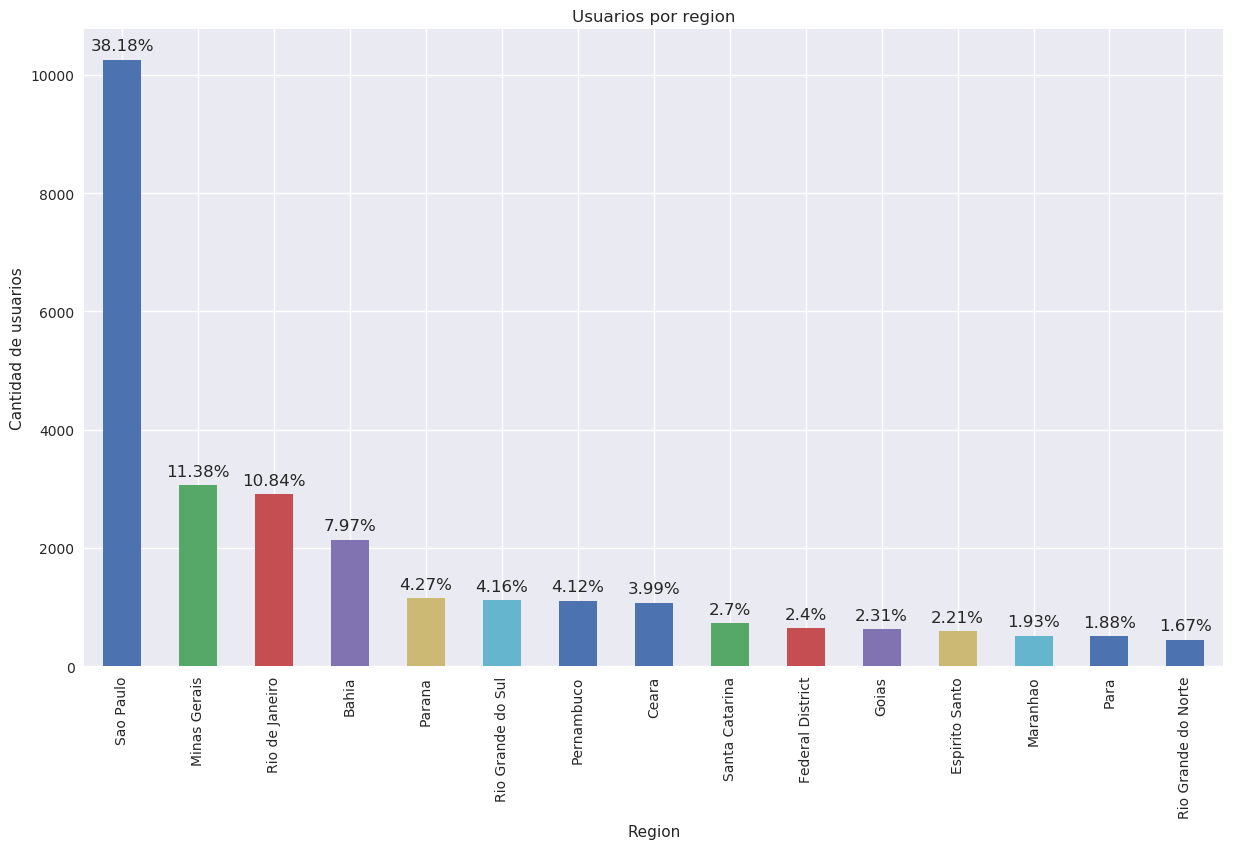

In [93]:
#Filtramos los 'Unknown'
visitas_brasil = visitas_brasil[visitas_brasil['region'] != 'Unknown']

sns.set(rc={'figure.figsize':(14.7,8.27)})
ax = visitas_brasil['region'].value_counts().head(15).plot('bar')
ax.set(xlabel='Region', ylabel='Cantidad de usuarios')
ax.set_title('Usuarios por region')
mostrar_porcentaje_barplot(ax)

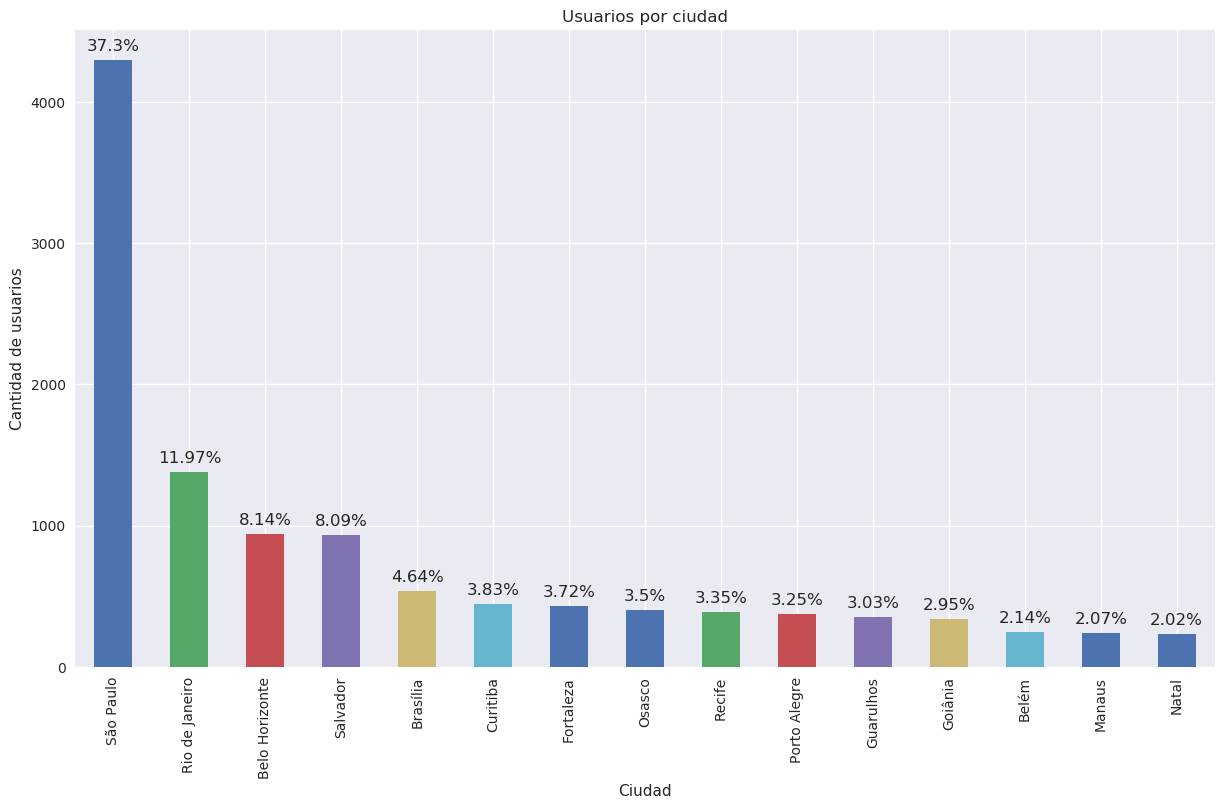

In [94]:
visitas_brasil = visitas_brasil[visitas_brasil['city'] != 'Unknown']
ax = visitas_brasil['city'].value_counts().head(15).plot('bar')
ax.set(xlabel='Ciudad', ylabel='Cantidad de usuarios')
ax.set_title('Usuarios por ciudad')
mostrar_porcentaje_barplot(ax)
sns.set(rc={'figure.figsize':(14.7,8.27)})

## Captacion de usuarios

In [95]:
personas_new_ret = df.loc[df["event"] == "visited site", ['person', 'new_vs_returning']]
personas_new_ret['returning_hits'] = personas_new_ret['new_vs_returning'] == 'Returning'
personas_new_ret.drop(columns='new_vs_returning', inplace=True)
personas_new_ret.head()

,person,returning_hits
1,0004b0a2,False
5,0006a21a,False
9,000a54b2,False
16,000a54b2,True
45,00184bf9,False


In [96]:
personas_ret_hits = personas_new_ret.groupby(by = 'person').agg({'returning_hits': np.count_nonzero})
personas_ret_hits.head(10)

,returning_hits
person,
0004b0a2,0
0006a21a,0
000a54b2,1
00184bf9,1
0019c395,0
001bb7eb,1
001f1653,0
00204059,11
0024a82b,0


In [97]:
x = personas_ret_hits['returning_hits']
x.value_counts().head(10)

0    15768
1     3896
2     1987
3     1192
4      762
5      557
6      419
7      331
8      228
9      201
Name: returning_hits, dtype: int64

Text(0.5,0,'Cantidad de returning_hits')

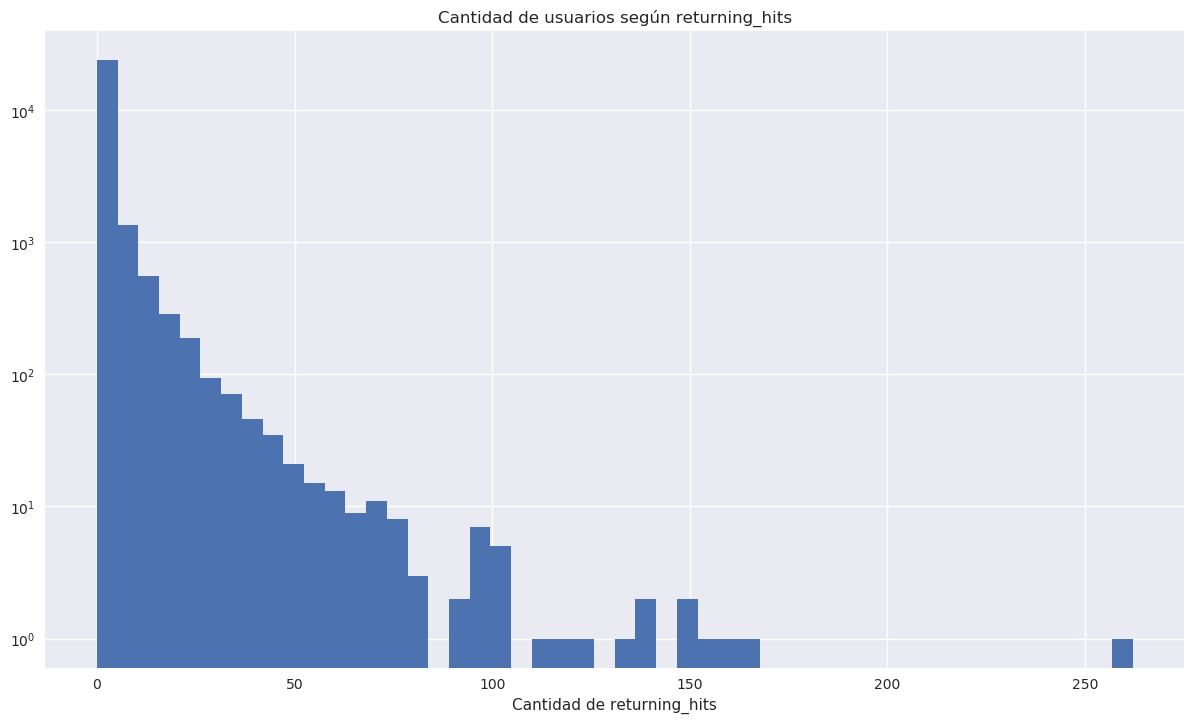

In [98]:
ax = x.hist(bins = 50)
ax.set_yscale('log')
ax.set_title('Cantidad de usuarios según returning_hits')
ax.set_xlabel('Cantidad de returning_hits')

La mayoría de los usuarios ingresa al sitio una única vez

[Text(0,0.5,'Cantidad de Usuarios'),
 Text(0.5,0,'Cantidad de visitas al sitio'),
 Text(0.5,1,'Cantidad de usuarios segun veces que visitaron el sitio')]

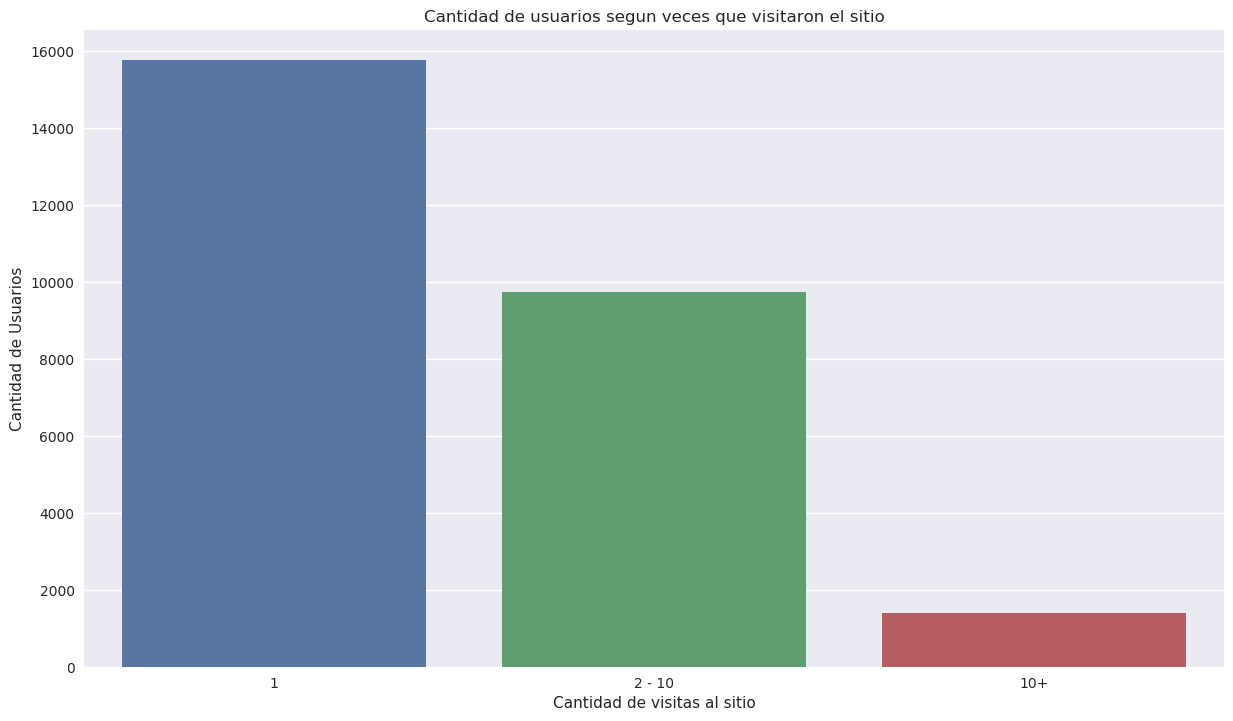

In [99]:
cant_returns = x.value_counts()
cero_returns = cant_returns[0]
uno_diez_returns = cant_returns[1:11].values.sum()
diez_mas_returns = cant_returns[11:].values.sum()
datos_returns = [cero_returns, uno_diez_returns, diez_mas_returns]
x_labels = ['1', '2 - 10', '10+']
ax = sns.barplot(x = x_labels, y = datos_returns)
ax.set(xlabel='Cantidad de visitas al sitio', ylabel='Cantidad de Usuarios', title = 'Cantidad de usuarios segun veces que visitaron el sitio')

La mayoria de los usuarios visita el sitio una única vez, mientras que solo una pequeña proporción volvió al sitio mas de 10 veces. Es posible que un mismo usuario entre desde dispositivos diferentes.

## Analisis temporal

In [100]:
#Analizamos periodo de los datos
df['timestamp'].dt.year.value_counts()

2018    1011288
Name: timestamp, dtype: int64

Todos los datos son de 2018

In [101]:
df['timestamp'].dt.month_name().value_counts()

May         474949
June        281882
April       130008
March        77293
February     27886
January      19270
Name: timestamp, dtype: int64

De los primeros dos trimestres del año

Text(0.5,1,'Cantidad de eventos por dia de la semana')

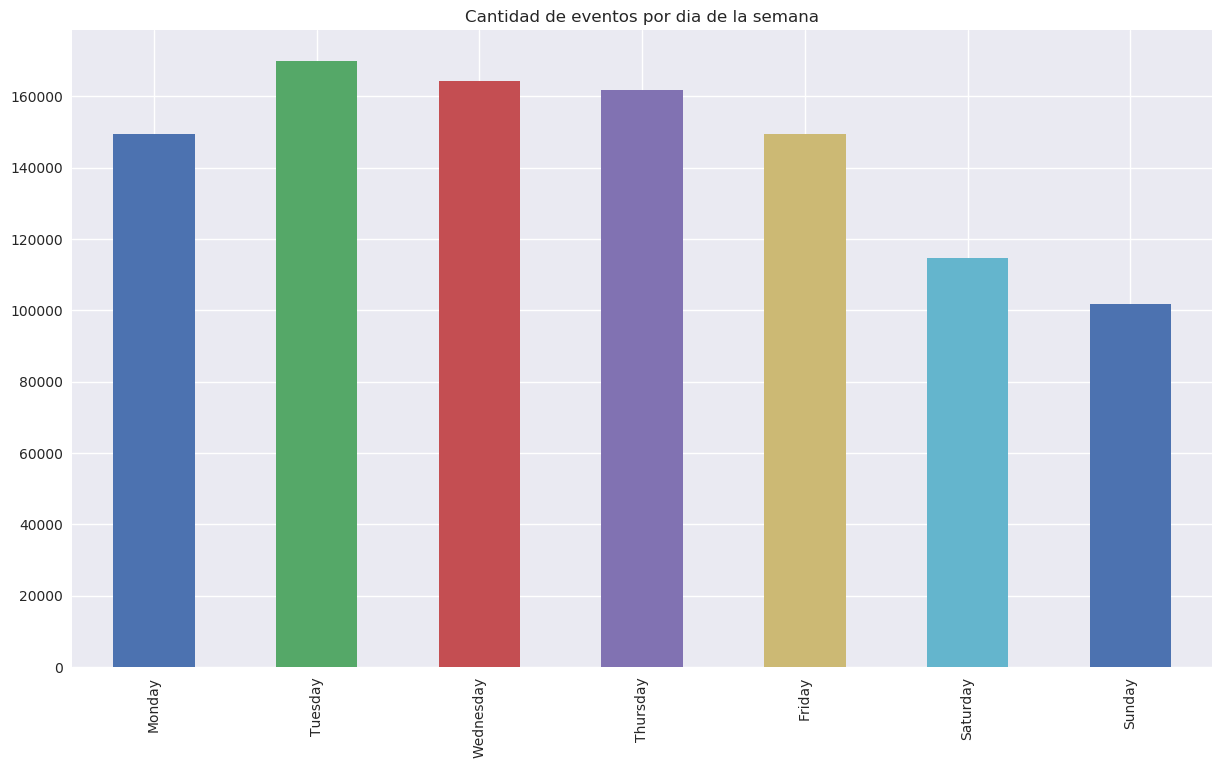

In [102]:
#Vamos a hacer un analisis sobre los dias en los que se produjeron los eventos
dias_semana = df['timestamp'].dt.weekday_name
dias_ordenados = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dias_semana = pd.Categorical(dias_semana, categories = dias_ordenados, ordered = True)
g = dias_semana.value_counts().plot('bar')
g.set_title('Cantidad de eventos por dia de la semana')

Vemos que durante el fin de semana el trafico es menor

In [139]:
tiempo_eventos = pd.DataFrame()
tiempo_eventos['event'] = df['event']
tiempo_eventos['dia_semana'] = df['timestamp'].dt.weekday_name
tiempo_eventos['dia'] = df['timestamp'].dt.day
tiempo_eventos['hora'] = df['timestamp'].dt.hour
tiempo_eventos['mes'] = df['timestamp'].dt.month_name()

#hora_weekday_organic = tiempo_eventos[tiempo_eventos['channel'] == 'organic'].groupby('dia_semana')['hora'].value_counts().to_frame()
#hora_weekday_paid = tiempo_eventos[tiempo_eventos['channel'] == 'paid'].groupby('dia_semana')['hora'].value_counts().to_frame()

hora_weekday_visitas = tiempo_eventos[tiempo_eventos['event'] == 'visited site'].groupby('dia_semana')['hora'].value_counts().to_frame()
hora_weekday_visitas = hora_weekday_visitas.rename(columns = {'hora':'cant_casos'})
hora_weekday_visitas = hora_weekday_visitas.reset_index('hora')
hora_weekday_visitas.index = pd.CategoricalIndex(hora_weekday_visitas.index, categories= reversed(dias_ordenados))
hora_weekday_visitas.sort_index(level=0, inplace=True)
hora_weekday_visitas = hora_weekday_visitas.reset_index()

dia_mes_visitas = tiempo_eventos[tiempo_eventos['event'] == 'visited site'].groupby('mes')['dia'].value_counts().to_frame()
dia_mes_visitas = dia_mes_visitas.rename(columns = {'dia':'cant_casos'})
dia_mes_visitas = dia_mes_visitas.reset_index('dia')
dia_mes_visitas.index = pd.CategoricalIndex(dia_mes_visitas.index, categories= ['January', 'February', 'March', 'April', 'May', 'June'])
dia_mes_visitas.sort_index(level=0, inplace=True)
dia_mes_visitas = dia_mes_visitas.reset_index()

[Text(0,0.5,'Lunes'),
 Text(0,1.5,'Martes'),
 Text(0,2.5,'Miercoles'),
 Text(0,3.5,'Jueves'),
 Text(0,4.5,'Viernes'),
 Text(0,5.5,'Sabado'),
 Text(0,6.5,'Domingo')]

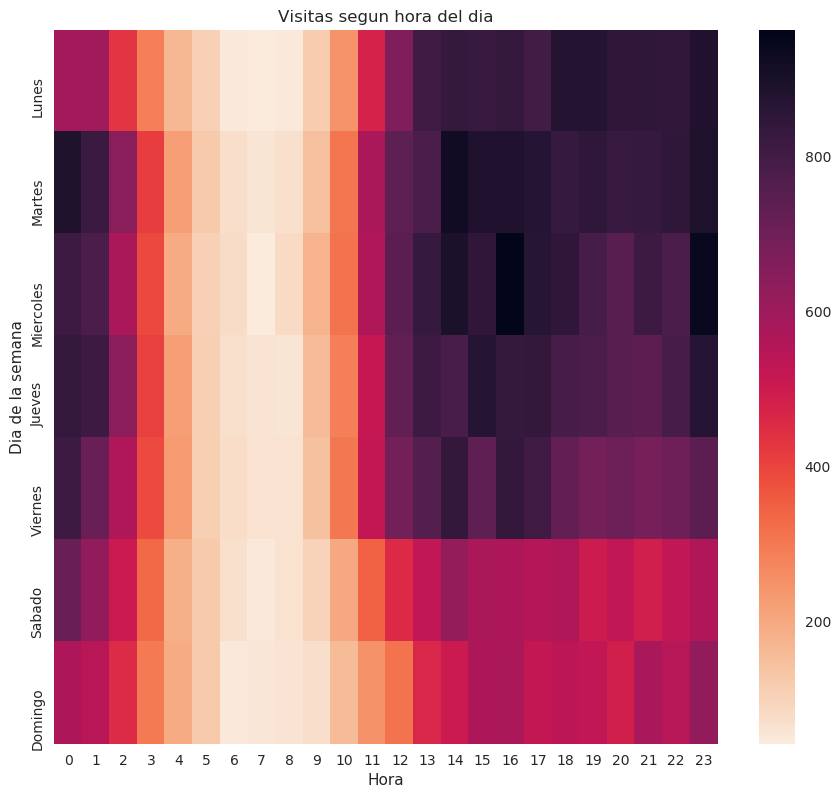

In [140]:
pivot = hora_weekday_visitas.pivot_table(index = 'dia_semana', columns = 'hora', values = 'cant_casos')
cmap = sns.cm.rocket_r
ax = sns.heatmap(data = pivot, cmap = cmap)
ax.set(xlabel='Hora', ylabel='Dia de la semana', title = 'Visitas segun hora del dia')
ax.set_yticklabels(reversed(['Lunes', 'Martes', 'Miercoles', 'Jueves', 'Viernes', 'Sabado', 'Domingo']))

Durante el fin de semana la cantidad de visitas es menor, mientras que la mayoria de las visitas se realizan entre las 12 y las 2

[Text(0.5,0,'Enero'),
 Text(1.5,0,'Febrero'),
 Text(2.5,0,'Marzo'),
 Text(3.5,0,'Abril'),
 Text(4.5,0,'Mayo'),
 Text(5.5,0,'Junio')]

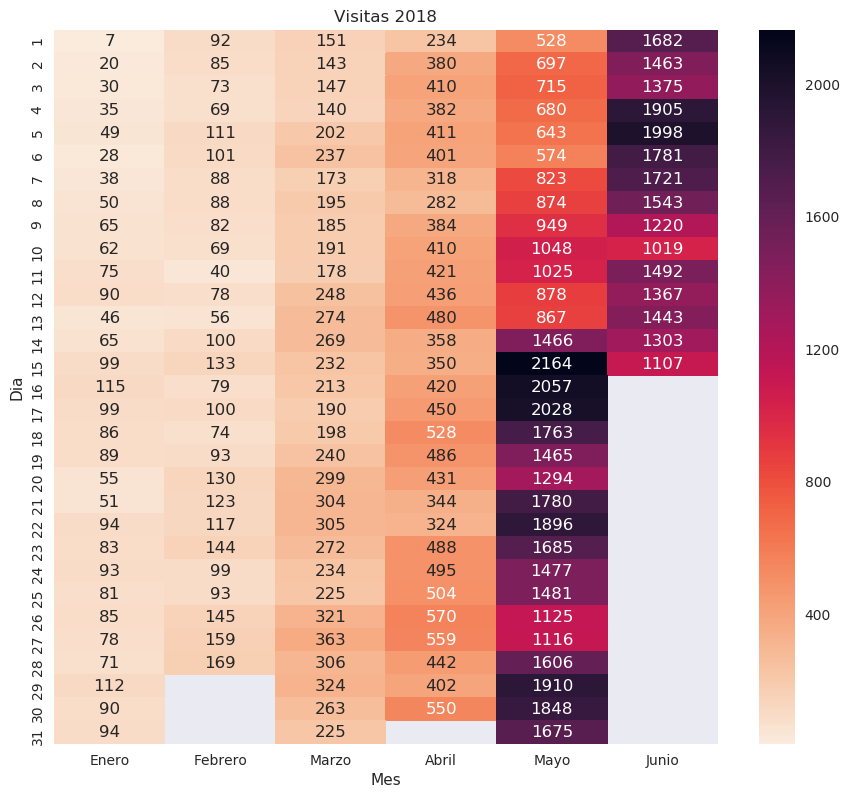

In [105]:
pivot = dia_mes_visitas.pivot_table(index = 'dia', columns = 'mes', values = 'cant_casos')
cmap = sns.cm.rocket_r
sns.set(rc={'figure.figsize':(10.7,9.27)})
ax = sns.heatmap(data = pivot, cmap = cmap, annot = True, fmt=".0f")
ax.set(xlabel='Mes', ylabel='Dia', title = 'Visitas 2018')
ax.set_xticklabels(['Enero','Febrero','Marzo','Abril','Mayo','Junio'])

Las visitas crecieron aceleradamente a lo largo del año, logrando un despegue a partir de mayo. Analizaremos las causas de esto mas adelante

## Origen de las visitas

In [106]:
visitas = df.loc[df["event"] == "visited site", ['timestamp', 'person', 'channel', 'new_vs_returning', 'city', 'region', 'country', 'device_type', 'screen_resolution', 'operating_system_version', 'browser_version']]
colors = {'Paid': 'navy', 'Direct': 'g', 'Organic': 'coral', 'Referral': 'm', 'Social': 'goldenrod', 'Email': 'k', 'Unknown': 'grey'}

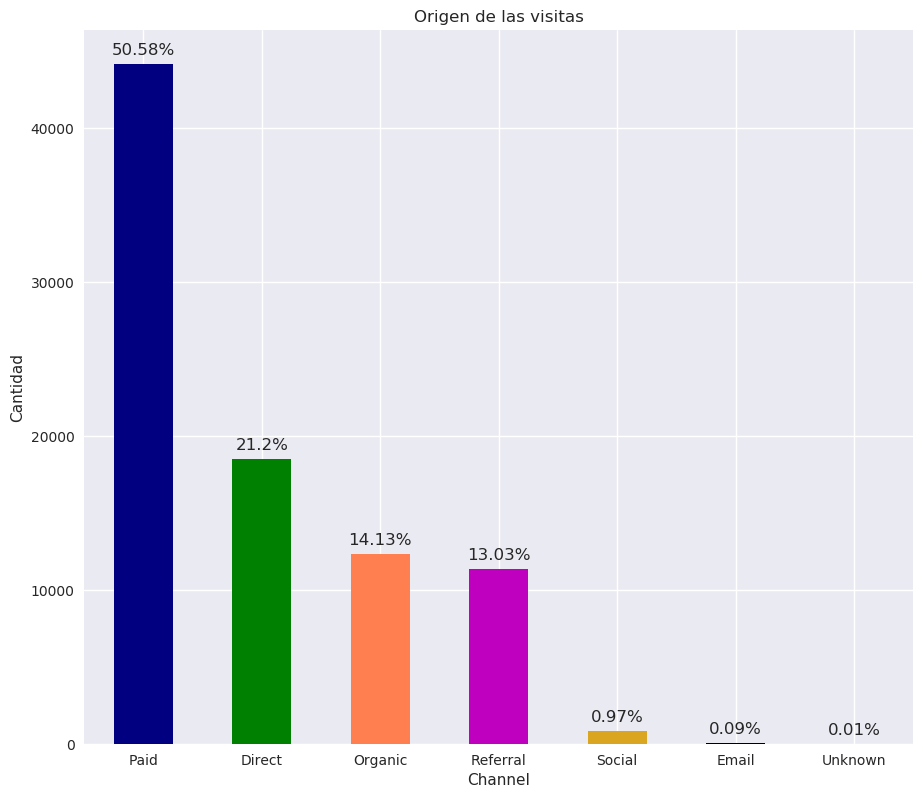

In [107]:
valores = visitas['channel'].value_counts()
ax = valores.plot(kind = 'bar', color=[colors.get(i) for i in valores.index])
ax.set_title('Origen de las visitas')
ax.set_ylabel('Cantidad')
ax.set_xlabel('Channel')
plt.xticks(rotation=0)
mostrar_porcentaje_barplot(ax)

### Origen de usuarios nuevos

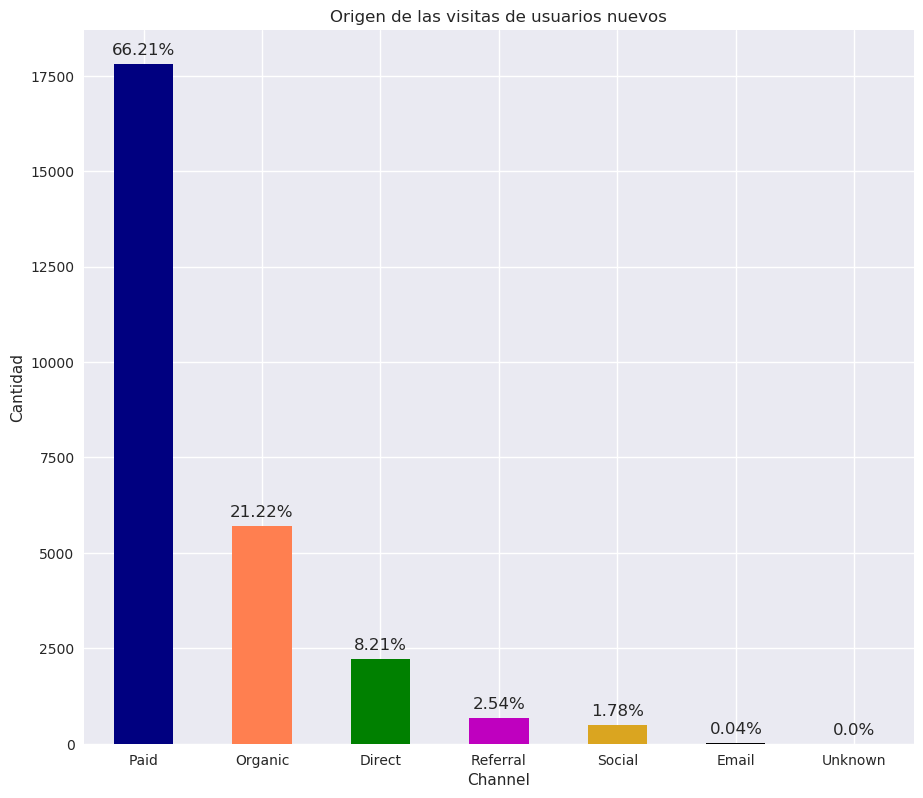

In [108]:
valores = visitas[visitas['new_vs_returning'] == 'New']['channel'].value_counts()
ax = valores.plot(kind = 'bar', color=[colors.get(i) for i in valores.index])
ax.set_title('Origen de las visitas de usuarios nuevos')
ax.set_ylabel('Cantidad')
ax.set_xlabel('Channel')
plt.xticks(rotation=0)
mostrar_porcentaje_barplot(ax)

#### Evolucion canales a lo largo del tiempo para usuarios nuevos

[Text(0,0.5,'Porcentaje'),
 Text(0.5,0,'Mes'),
 Text(0.5,1,'Proporcion de visitas usuarios nuevos por channel')]

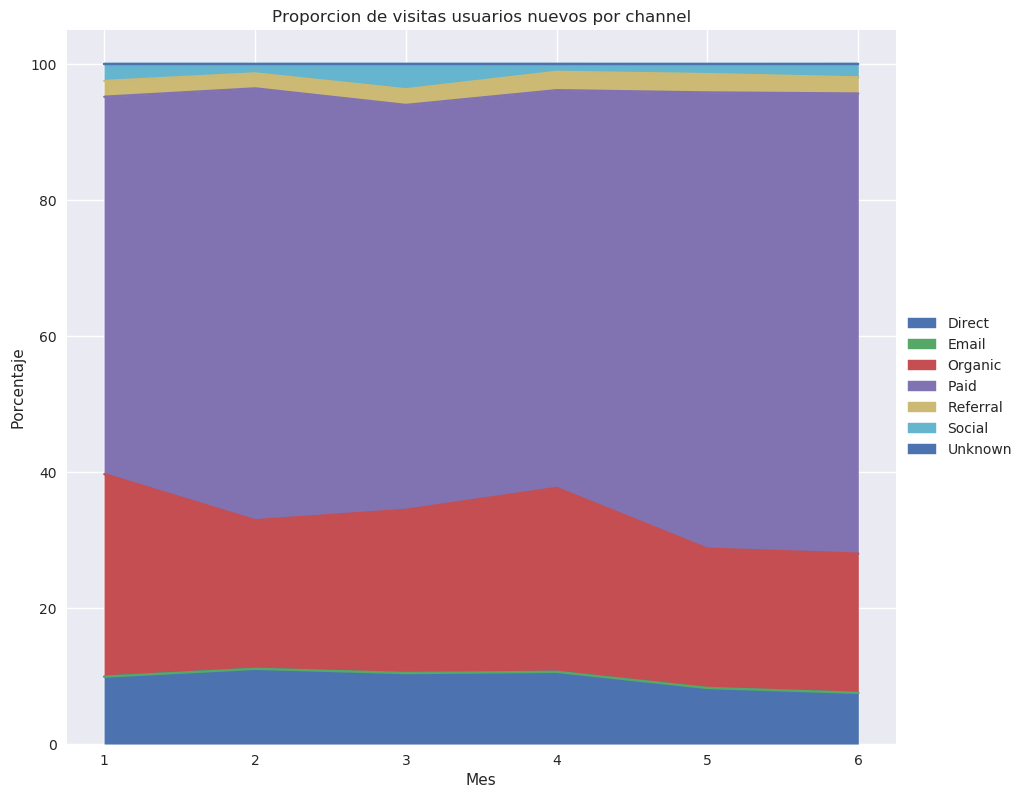

In [109]:
evolucion_semanal = visitas.copy()
evolucion_semanal['mes'] = evolucion_semanal['timestamp'].dt.month
evolucion_semanal = evolucion_semanal[evolucion_semanal['new_vs_returning'] == 'New']

evolucion_semanal = pd.crosstab(evolucion_semanal['mes'], evolucion_semanal['channel'])
evolucion_semanal = evolucion_semanal.div(evolucion_semanal.sum(axis=1), axis=0).multiply(100)

ax = evolucion_semanal.plot(kind = 'area')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set(xlabel='Mes', ylabel='Porcentaje', title = 'Proporcion de visitas usuarios nuevos por channel')

Vemos que los porcentajes se mantienen mas o menos constantes a lo largo del tiempo

### Origen usuarios no nuevos

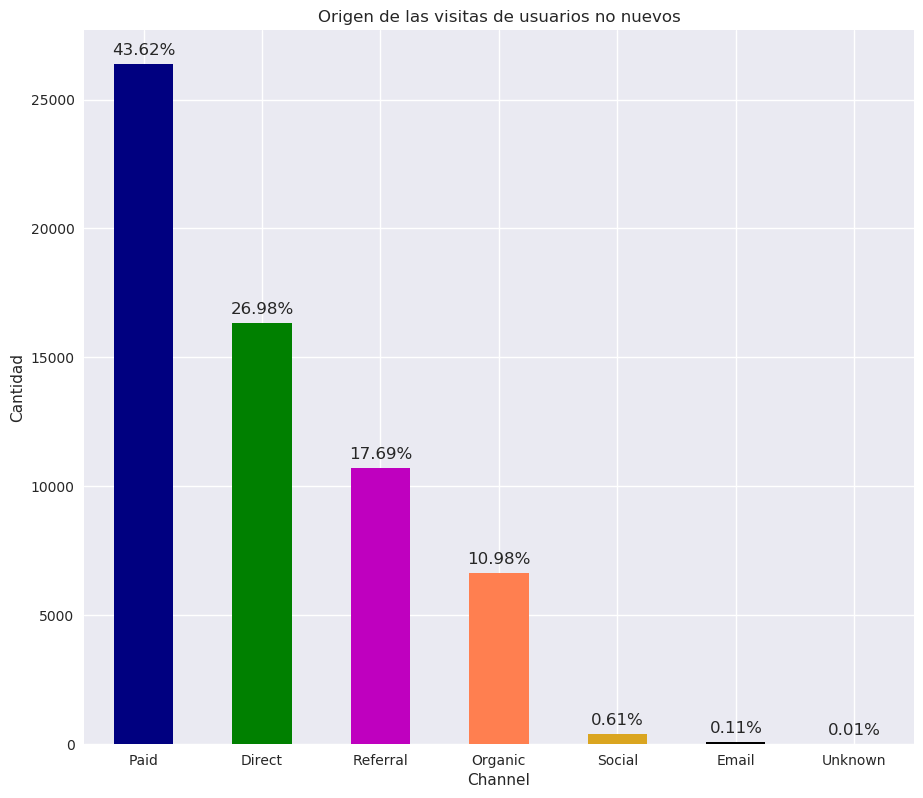

In [110]:
valores = visitas[visitas['new_vs_returning'] == 'Returning']['channel'].value_counts()
ax = valores.plot(kind = 'bar', color=[colors.get(i) for i in valores.index])
ax.set_title('Origen de las visitas de usuarios no nuevos')
ax.set_ylabel('Cantidad')
ax.set_xlabel('Channel')
plt.xticks(rotation=0)
mostrar_porcentaje_barplot(ax)

Vemos que el canal pago es el que mas visitas atrae, no solo para usuarios nuevos sino tambien para usuarios que ya habian entrado al sitio. Por otro lado, se puede ver como el canal "Direct" (tipeado de URL, acceso mediante favoritos y similares) toma protagonismo para visitas de usuarios que ya conocen el sitio. Pero esto puede ser causado por un pequeño numero de usuarios que visitan repetidas veces el sitio

#### Evolución de los canales para visitas de usuarios no nuevos

[Text(0,0.5,'Porcentaje'),
 Text(0.5,0,'Mes'),
 Text(0.5,1,'Proporcion de visitas usuarios no nuevos por channel')]

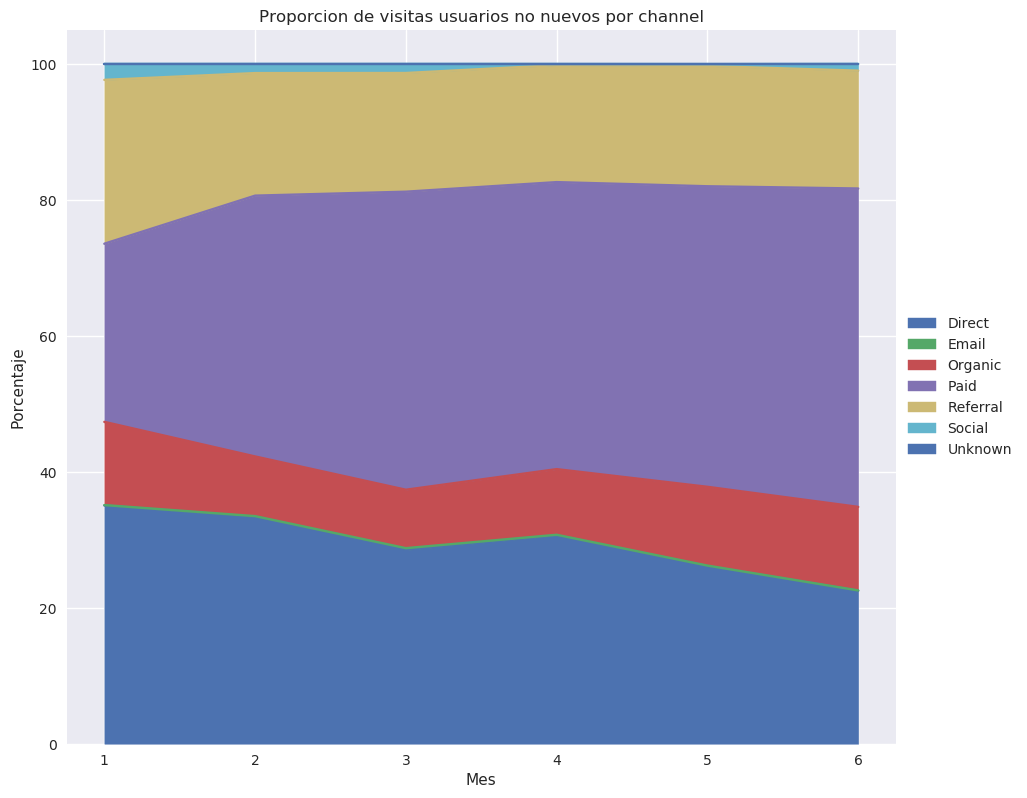

In [142]:
evolucion_semanal = visitas
evolucion_semanal['mes'] = evolucion_semanal['timestamp'].dt.month
evolucion_semanal = evolucion_semanal[evolucion_semanal['new_vs_returning'] == 'Returning']

evolucion_semanal = pd.crosstab(evolucion_semanal['mes'], evolucion_semanal['channel'])
evolucion_semanal = evolucion_semanal.div(evolucion_semanal.sum(axis=1), axis=0).multiply(100)

ax = evolucion_semanal.plot(kind = 'area')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set(xlabel='Mes', ylabel='Porcentaje', title = 'Proporcion de visitas usuarios no nuevos por channel')

Vemos un aumento en proporcion del canal pago y una disminucion del canal directo a lo largo del tiempo.

Ahora tomaremos solo un metodo predominante de acceso al sitio por usuario, para usarios no nuevos

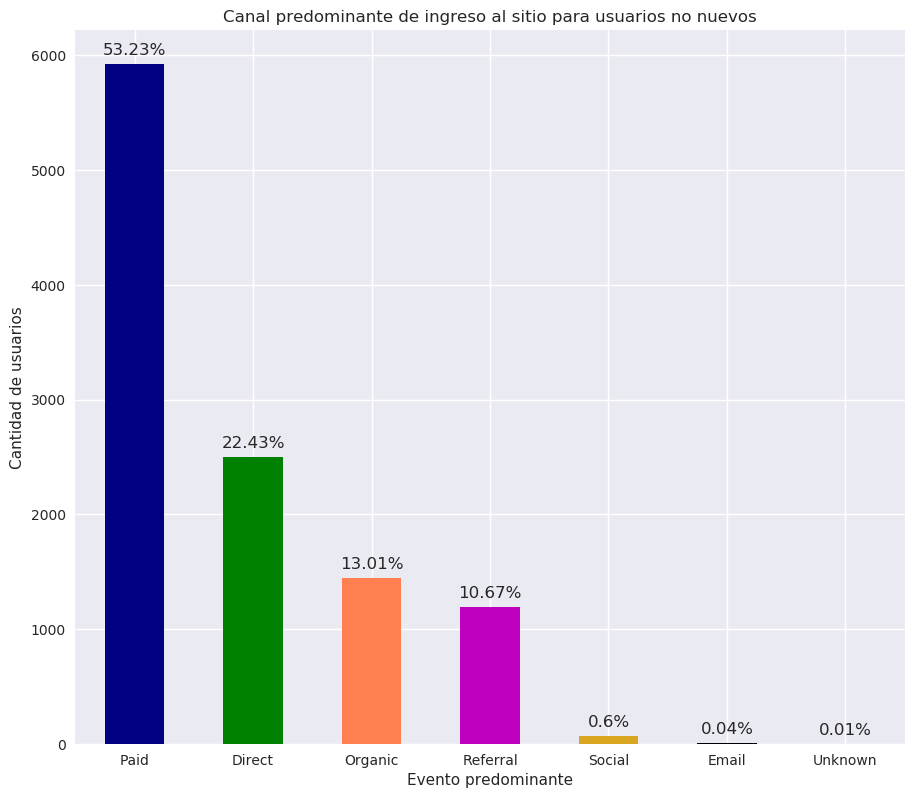

In [112]:
valores = visitas[visitas['new_vs_returning'] == 'Returning'].groupby('person')['channel'].value_counts()
valores = valores.reset_index(level='channel', name='Counts')
valores = valores[~valores.index.duplicated(keep='first')]['channel'].value_counts()
                  
ax = valores.plot(kind = 'bar', color=[colors.get(i) for i in valores.index])
ax.set_title('Canal predominante de ingreso al sitio para usuarios no nuevos')
ax.set_ylabel('Cantidad de usuarios')
ax.set_xlabel('Evento predominante')
plt.xticks(rotation=0)
mostrar_porcentaje_barplot(ax)

Vemos que en este caso el canal predominante de ingreso al sitio para usuarios no nuevos sigue siendo el canal pago, aunque con menor proporcion que para usuarios nuevos. El ingreso mediante "referrals" de otros sitios queda en segundo lugar, teniendo una proporcion mucho mayor que para usuarios nuevos.

## Los usuarios que hicieron checkout. ¿Concretaron la conversión?

In [113]:
checkouts = df.loc[df['event'] == 'checkout',["sku","timestamp","person","model","condition","storage","color"]]
conversiones = df.loc[df['event'] == 'conversion',["sku","timestamp","person","model","condition","storage","color"]]

### Observemos la evolución de los checkouts en el tiempo

Text(0.5,1,'Checkouts semanales')

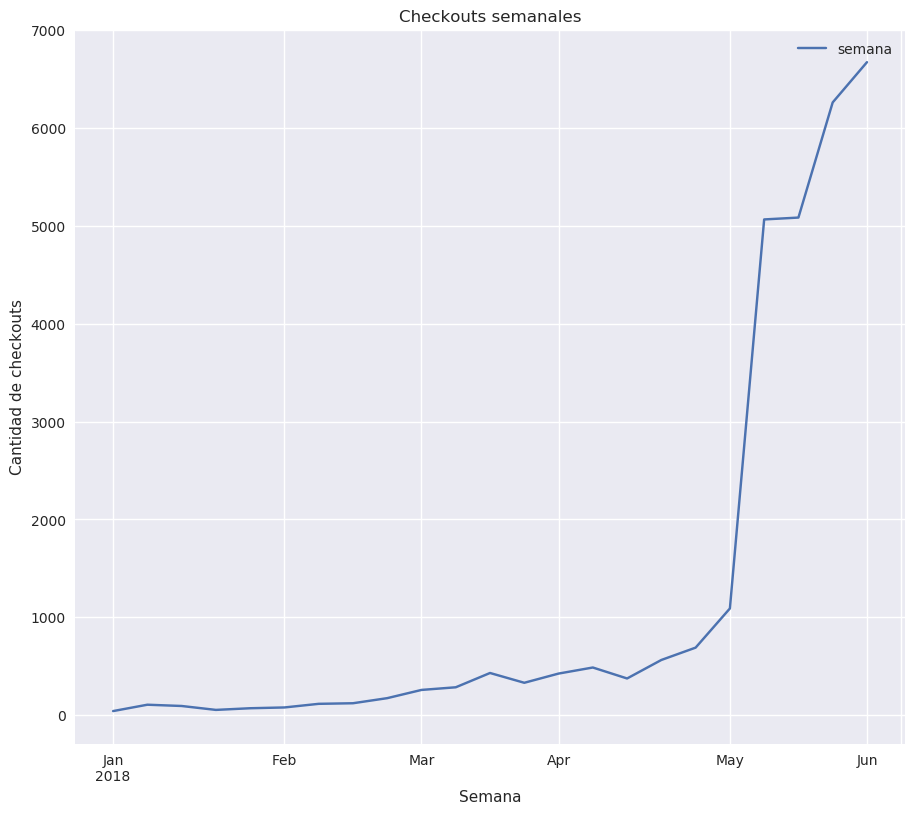

In [202]:
checkouts_by_week = checkouts.loc[:, ['timestamp']]
checkouts_by_week['semana'] = checkouts_by_week['timestamp'].dt.week - 1
checkouts_by_week = checkouts_by_week[checkouts_by_week['semana'] != checkouts_by_week['semana'].max()] #Borro la ultima semana incompleta
checkouts_by_week['semana'] = pd.to_datetime('2018', format='%Y') + pd.to_timedelta(checkouts_by_week['semana'].mul(7).astype('str') + ' days')

checkouts_weeks = checkouts_by_week['semana'].value_counts().to_frame().sort_index()
ax = checkouts_weeks.plot()
ax.set(xlabel='Semana', ylabel='Cantidad de checkouts')
ax.set_title('Checkouts semanales')

Aparentemente, algo ocurrió a mitad de Mayo. Haciendo zoom podemos ver que el 14 comenzaron a aumentar los checkouts.

Text(0.5,1,'Checkouts 11/05 al 17/05')

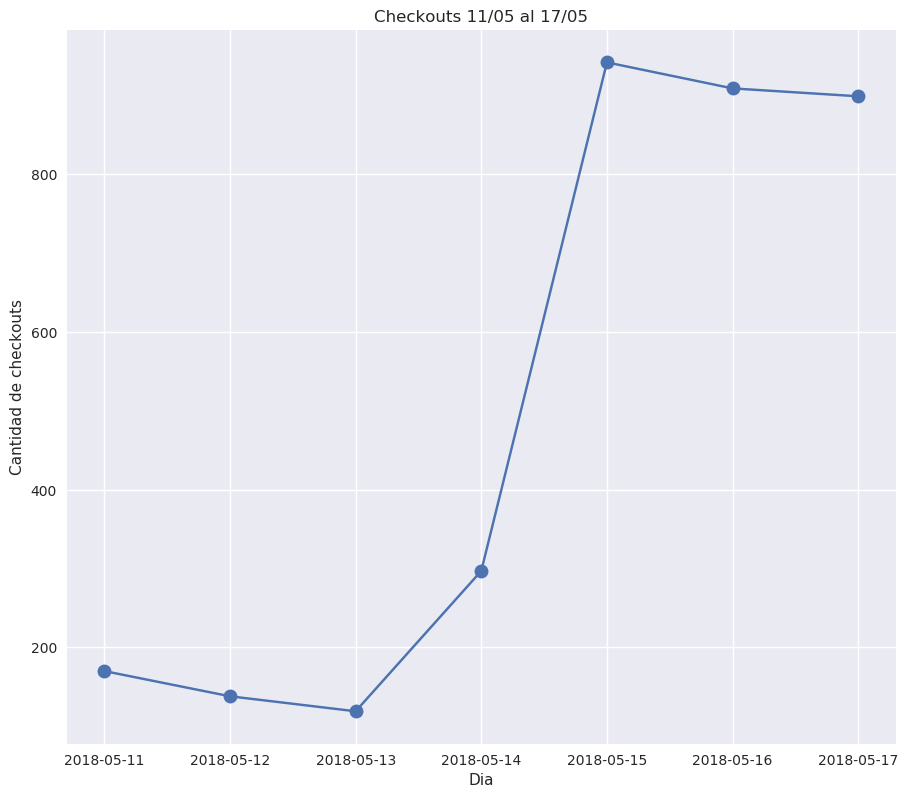

In [183]:
acotado = checkouts.loc[(checkouts['timestamp'] > pd.to_datetime("2018-05-11")) & (checkouts['timestamp'] < pd.to_datetime("2018-05-18"))].copy()
acotado['fecha'] = acotado['timestamp'].dt.date

ax = acotado['fecha'].value_counts().plot(marker=".",markersize="20")
ax.set(xlabel='Dia', ylabel='Cantidad de checkouts')
ax.set_title('Checkouts 11/05 al 17/05')

Ahora analicemos la evolución de las conversiones.

Text(0.5,1,'Conversiones semanales')

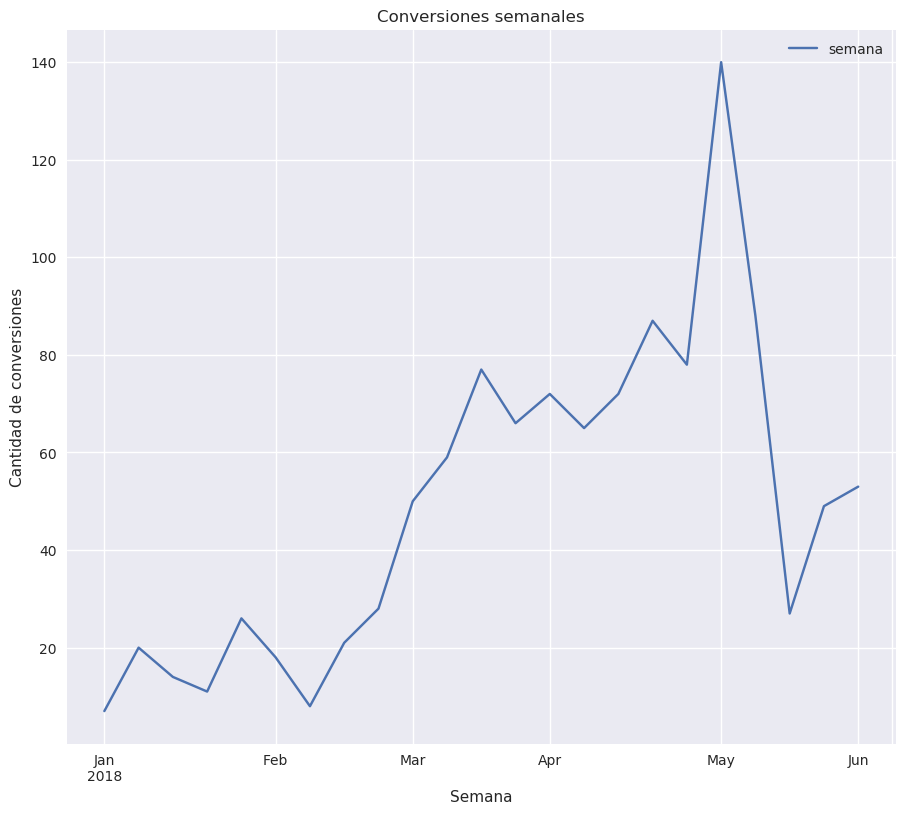

In [203]:
conversiones_by_week = conversiones.loc[:, ["timestamp"]]
conversiones_by_week['semana'] = conversiones_by_week['timestamp'].dt.week - 1
conversiones_by_week = conversiones_by_week[conversiones_by_week['semana'] != conversiones_by_week['semana'].max()] #Borro la ultima semana incompleta
conversiones_by_week['semana'] = pd.to_datetime('2018', format='%Y') + pd.to_timedelta(conversiones_by_week['semana'].mul(7).astype('str') + ' days')

conversiones_weeks = conversiones_by_week['semana'].value_counts().to_frame().sort_index()
ax = conversiones_weeks.plot()
ax.set(xlabel='Semana', ylabel='Cantidad de conversiones')
ax.set_title('Conversiones semanales')

Veamos si hay correlación entre el aumento de checkouts y las conversiones.

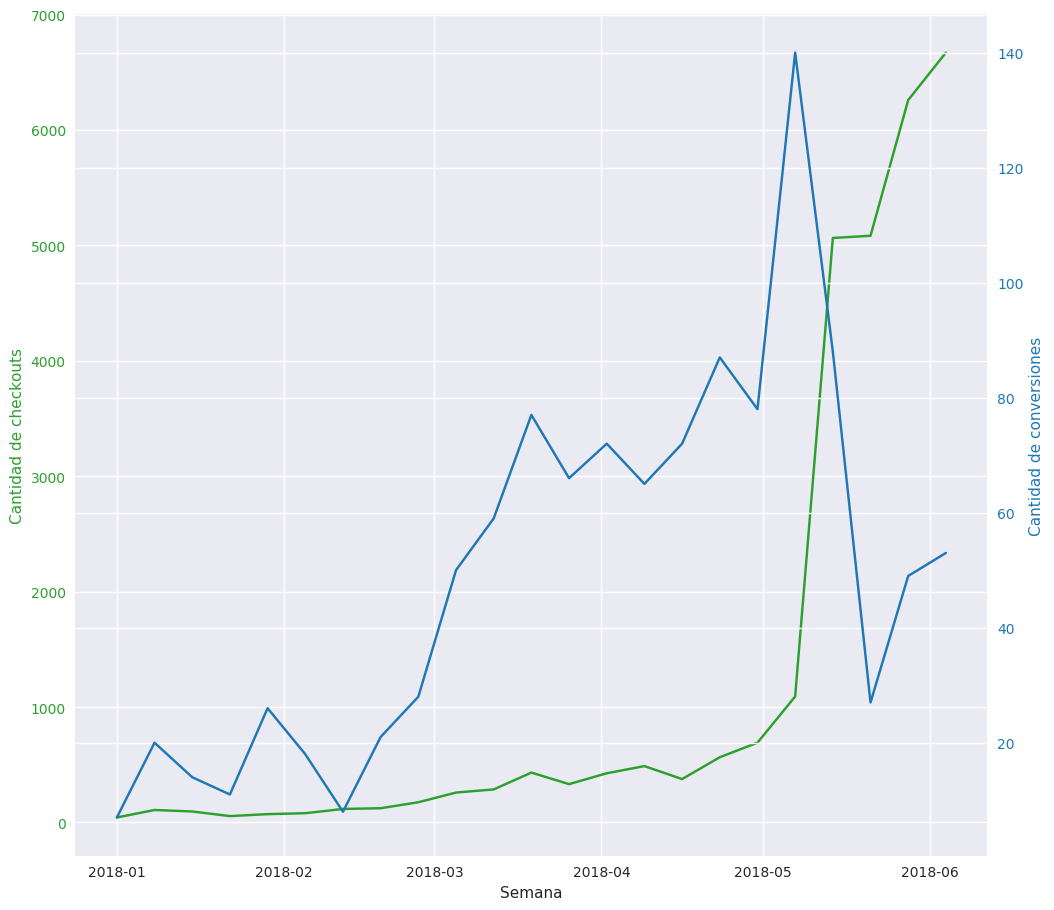

In [204]:
fig, ax1 = plt.subplots()

color = 'tab:green'
ax1.set_xlabel('Semana')
ax1.set_ylabel('Cantidad de checkouts', color=color)
ax1.plot(checkouts_weeks['semana'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Cantidad de conversiones', color=color)
ax2.plot(conversiones_weeks['semana'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()


Se observa un aumento significativo tanto de conversiones como de checkouts en la segunda semana de mayo, pero de ahi en adelante solo los checkouts siguieron aumentando mientras que las conversiones disminuyeron. Analizaremos la proporcion de conversiones sobre checkouts hasta esa semana.

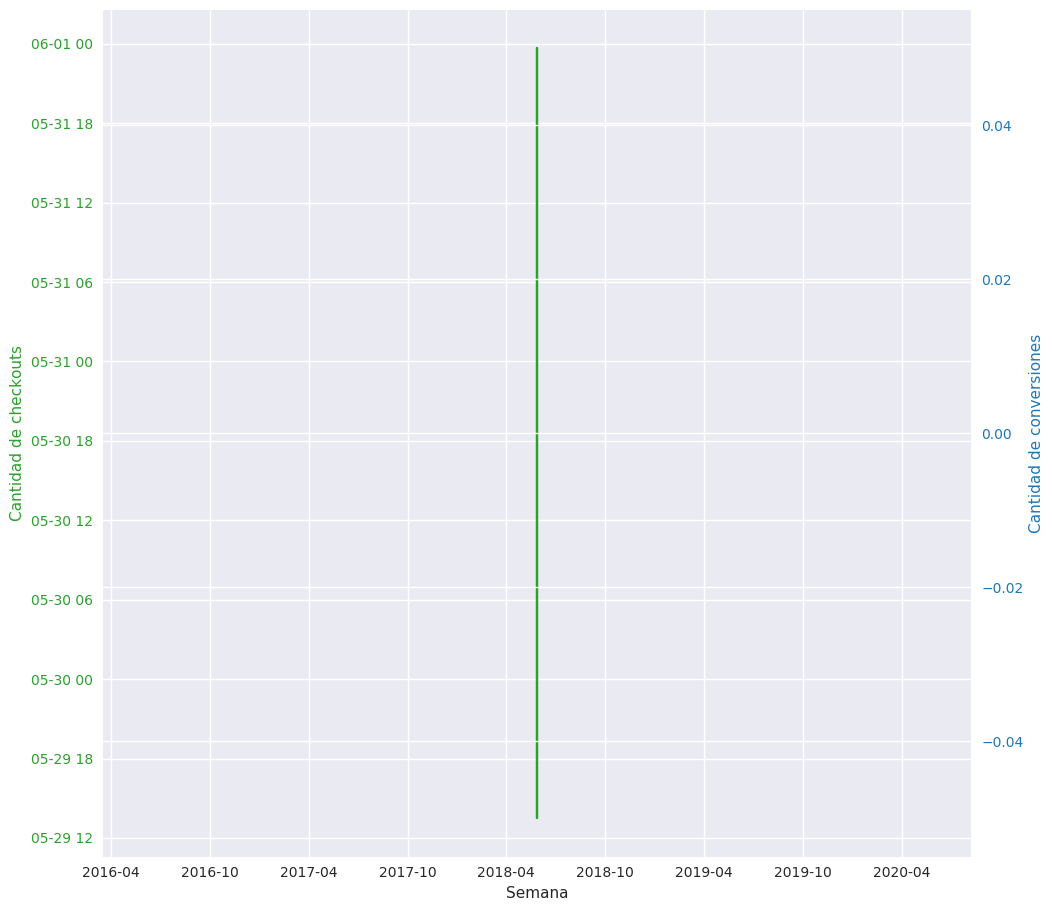

In [205]:
checkouts_hasta_mayo = checkouts_by_week.loc[0:18].set_index('semana')
conversiones_hasta_mayo = conversiones_by_week.loc[0:18].set_index('semana')

fig, ax1 = plt.subplots()

color = 'tab:green'
ax1.set_xlabel('Semana')
ax1.set_ylabel('Cantidad de checkouts', color=color)
ax1.plot(checkouts_hasta_mayo, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Cantidad de conversiones', color=color)
ax2.plot(conversiones_hasta_mayo, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

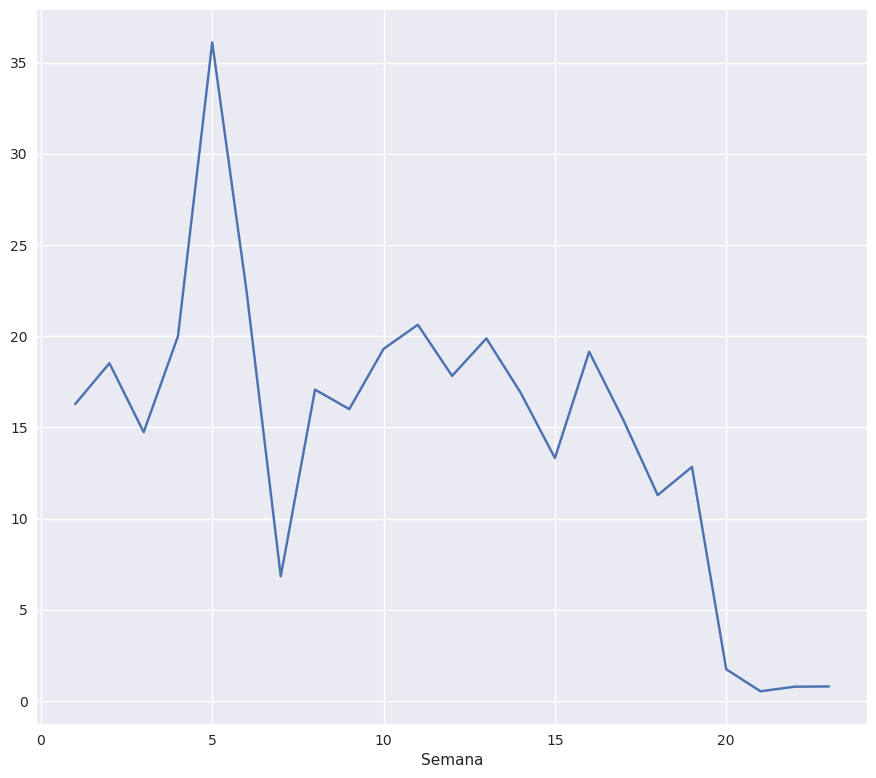

In [119]:
porcentaje_conversiones_sobre_checkouts = (conversiones_by_week['Conversiones'] / checkouts_by_week['Checkouts']) * 100
ax = porcentaje_conversiones_sobre_checkouts.plot()

Vemos que hasta mayo la cantidad de checkouts y conversiones estaban intimamente relacionadas, representando alrededor de un 15% la cantidad de conversiones sobre la cantidad de checkouts. Debemos analizar que sucede en mayo que hace que de ahi en adelante suban los checkouts pero bajen las conversiones.

### Marcas con mas checkouts y conversiones

In [120]:
def obtener_marca(serie_de_modelo):
    # La marca es siempre la primer palabra del modelo
    r = []
    for modelo in serie_de_modelo.tolist():
        if pd.isna(modelo):
            r.append("Unknown")
        else:
            r.append(modelo.split()[0])
    return r

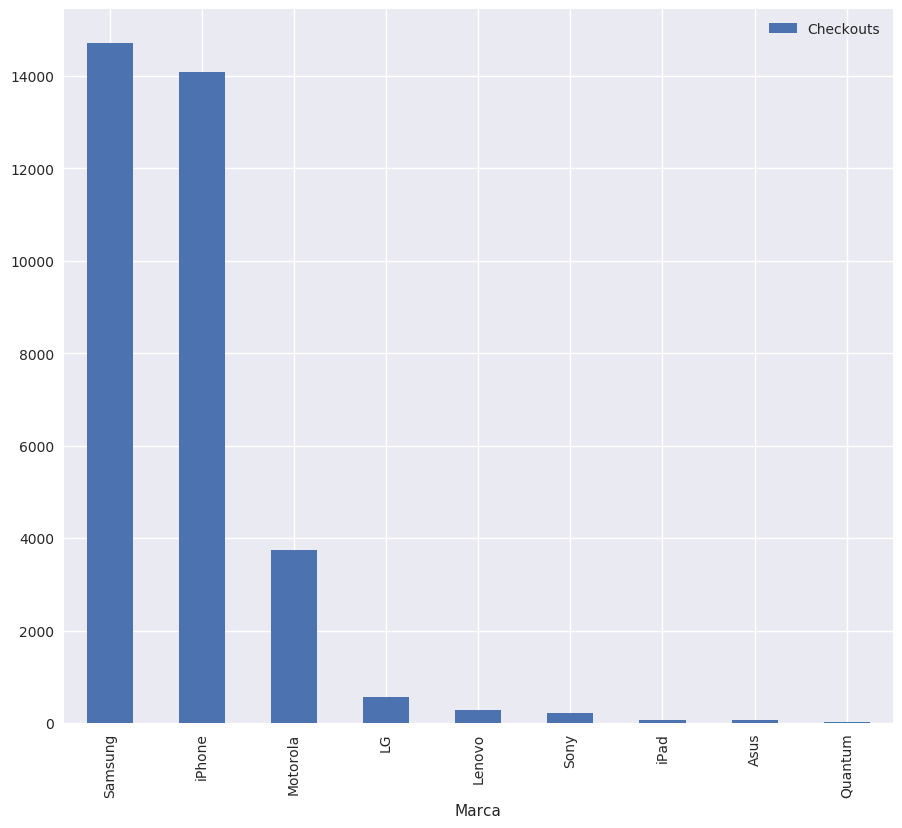

In [121]:
checkouts["Marca"] = obtener_marca(checkouts["model"])
checkouts = checkouts.loc[checkouts["Marca"] != "Unknown"] # Remuevo datos erroneos
checkouts["Checkouts"] = 1
checkouts_by_marca = checkouts[["Marca","Checkouts"]].groupby(by=["Marca"]).agg("count")\
    .sort_values(by="Checkouts",ascending=False)
checkouts_by_marca.plot(kind="bar")

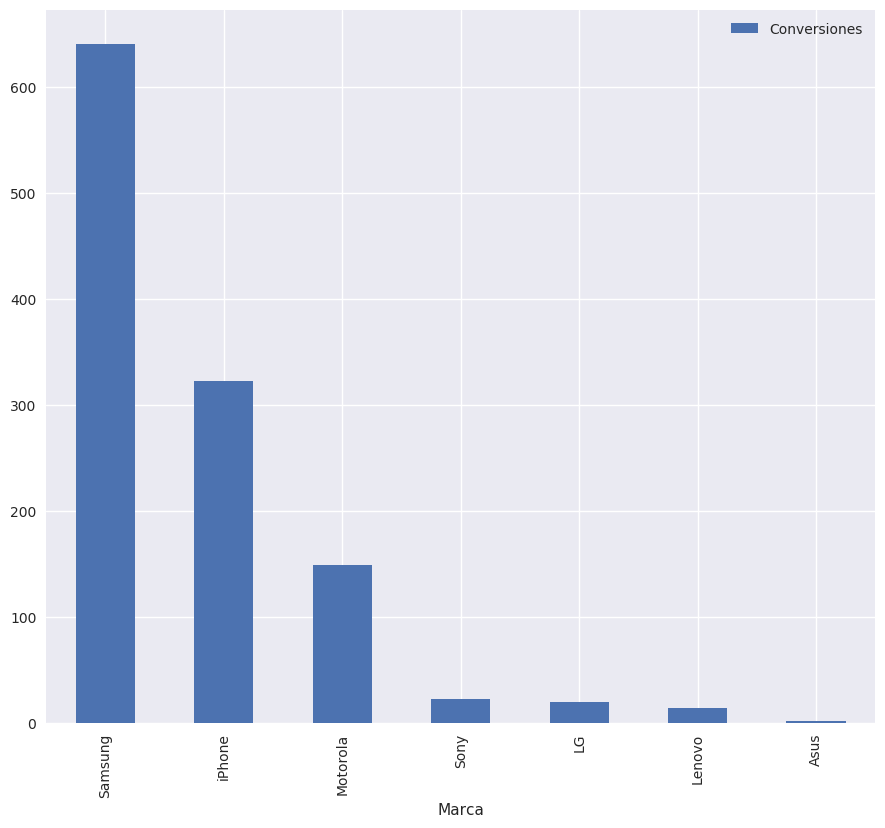

In [122]:
conversiones["Marca"] = obtener_marca(conversiones["model"])
conversiones = conversiones.loc[conversiones["Marca"] != "Unknown"] # Remuevo datos erroneos
conversiones["Conversiones"] = 1
conversiones_by_marca = conversiones[["Marca","Conversiones"]].groupby(by=["Marca"]).agg("count")\
    .sort_values(by="Conversiones",ascending=False)
conversiones_by_marca.plot(kind="bar")

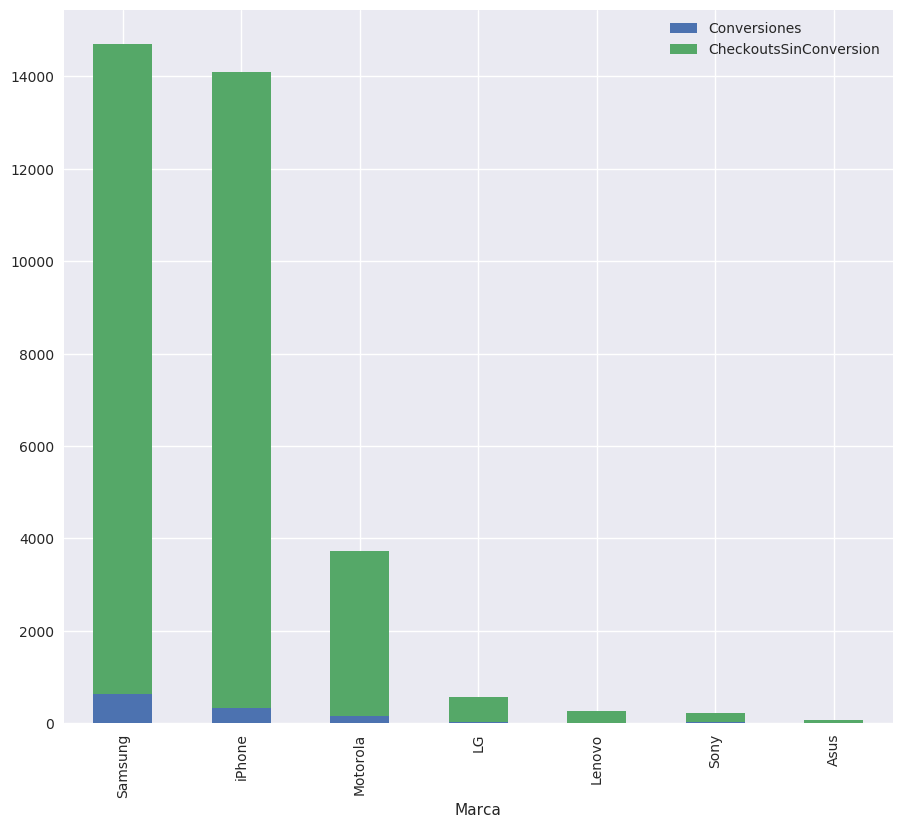

In [123]:
marca_stats = conversiones_by_marca.join(checkouts_by_marca).sort_values(by="Checkouts",ascending=False)
marca_stats["CheckoutsSinConversion"] = marca_stats["Checkouts"] - marca_stats["Conversiones"]
marca_stats.drop("Checkouts", axis=1, inplace= True)
marca_stats.plot(kind="bar",stacked=True)

In [124]:
#analizar
pd.crosstab(checkouts['condition'],checkouts['Marca']) # hacerlo en el otro notebook

Marca,Asus,LG,Lenovo,Motorola,Quantum,Samsung,Sony,iPad,iPhone
condition,,,,,,,,,
Bom,9,183,89,1633,7,8141,81,5,5157
Excelente,13,164,96,1035,7,3611,75,46,4094
Muito Bom,41,215,87,1070,5,2940,62,21,3743
Bom - Sem Touch ID,0,0,0,0,0,2,0,0,1088
Novo,0,0,0,0,0,13,0,0,0


#### Analsis de checkouts por persona

In [125]:
primer_evento_por_persona = df.loc[df['new_vs_returning']=='New',['timestamp','person']].set_index('person')


Veo si existen casos de double tracking

In [126]:
def min_diferencia_tiempo(df):
        min_diferencia=pd.to_timedelta('365 days')
        for i in range(1,len(df)):
            dif = df.iloc[i]-df.iloc[i-1]
            if dif<min_diferencia:
                min_diferencia = dif
        return min_diferencia    
            
checkouts_por_persona = df.loc[df['event']=='checkout',['timestamp','person','model', 'sku']]
duplicados = checkouts_por_persona[checkouts_por_persona.duplicated(subset=['person'], keep=False)]
min_diferencia_checkouts = duplicados.groupby('person').agg({'timestamp':min_diferencia_tiempo}).sort_values(by='timestamp')
min_diferencia_checkouts['menos_de_1seg'] = min_diferencia_checkouts['timestamp']<pd.to_timedelta('00:00:01')
min_diferencia_checkouts['menos_de_1seg'].value_counts()

False    1992
True        1
Name: menos_de_1seg, dtype: int64

Existe solo 1 caso de todos los checkouts que podría ser de double tracking, lo examino

In [127]:
min_diferencia_checkouts.loc[min_diferencia_checkouts['menos_de_1seg']==True]

,timestamp,menos_de_1seg
person,,
0ee73fbe,0 days,True


In [128]:
checkouts_por_persona.loc[checkouts_por_persona['person']=='0ee73fbe']

,timestamp,person,model,sku
52141,2018-04-11 14:25:45,0ee73fbe,Samsung Galaxy A5,3193.0
52193,2018-04-17 14:59:24,0ee73fbe,Samsung Galaxy Gran Prime 3G Duos,5281.0
52270,2018-04-25 14:26:42,0ee73fbe,Samsung Galaxy Gran Prime Duos TV,4561.0
52275,2018-04-25 14:27:33,0ee73fbe,Samsung Galaxy J5,6369.0
52276,2018-04-25 16:41:00,0ee73fbe,Samsung Galaxy J5,6369.0
52278,2018-04-25 16:41:02,0ee73fbe,Samsung Galaxy Gran Prime Duos TV,4561.0
52280,2018-04-25 17:14:23,0ee73fbe,Samsung Galaxy Gran Prime Duos TV,4561.0
52281,2018-04-25 17:14:23,0ee73fbe,Samsung Galaxy J5,6369.0
52324,2018-04-28 14:22:59,0ee73fbe,Samsung Galaxy J2 Prime TV,9358.0
52331,2018-04-30 14:40:19,0ee73fbe,Samsung Galaxy J2 Prime TV,9358.0


Los dos eventos de checkout que son en el mismo momento son de modelos distintos, por lo tanto supondremos que no es un caso de double tracking

### Analizo la cantidad de checkouts por persona 

In [129]:
checkouts_por_persona['checkouts'] = 1
checkouts_por_persona["marca"] = obtener_marca(checkouts_por_persona["model"])
for marca in ['Samsung','iPhone','Motorola','LG','Lenovo','Sony','Quantum','iPad','Asus']:
    checkouts_por_persona[marca] = checkouts_por_persona['marca'] == marca
checkouts_por_persona.head()    
    

,timestamp,person,model,sku,checkouts,marca,Samsung,iPhone,Motorola,LG,Lenovo,Sony,Quantum,iPad,Asus
3,2018-05-31 23:38:40,0004b0a2,iPhone 5s,2694.0,1,iPhone,False,True,False,False,False,False,False,False,False
7,2018-05-29 13:29:35,0006a21a,Samsung Galaxy S8,15338.0,1,Samsung,True,False,False,False,False,False,False,False,False
44,2018-05-24 11:34:32,000a54b2,Motorola Moto Z Play,12660.0,1,Motorola,False,False,True,False,False,False,False,False,False
85,2018-04-06 05:14:58,00184bf9,Samsung Galaxy J5,6355.0,1,Samsung,True,False,False,False,False,False,False,False,False
86,2018-04-06 05:18:15,00184bf9,Samsung Galaxy J5,6355.0,1,Samsung,True,False,False,False,False,False,False,False,False


Text(0,0.5,'Numero de personas')

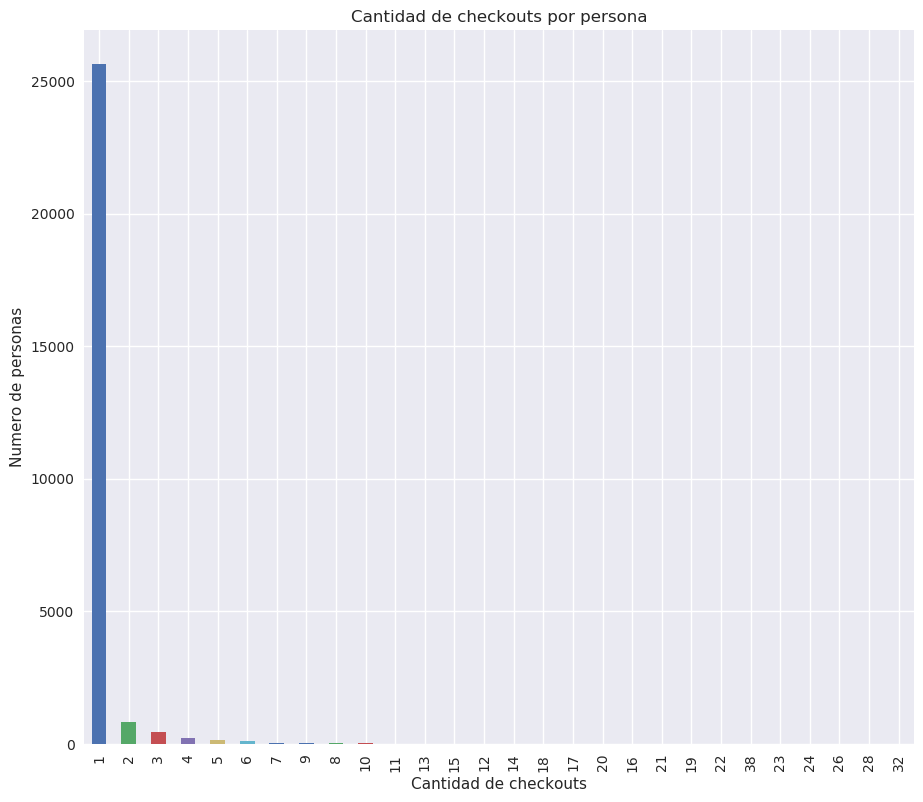

In [130]:

cantidad_de_checkouts_por_persona = checkouts_por_persona.groupby('person').agg({'checkouts':sum,\
        'Samsung':sum,'iPhone':sum,'Motorola':sum,'LG':sum,'Lenovo':sum,'Sony':sum,\
        'Quantum':sum,'iPad':sum,'Asus':sum})
g = cantidad_de_checkouts_por_persona['checkouts'].value_counts().plot('bar')
g.set_title('Cantidad de checkouts por persona')
g.set_xlabel('Cantidad de checkouts')
g.set_ylabel('Numero de personas')

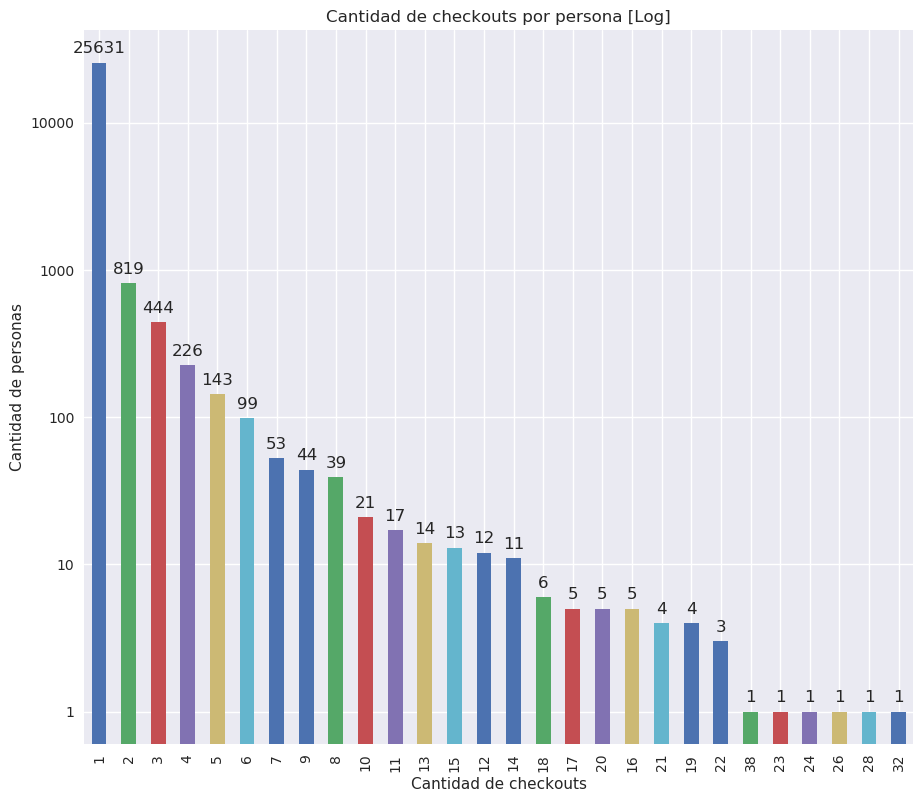

In [152]:
cant_checkouts_log=cantidad_de_checkouts_por_persona['checkouts'].value_counts()#.transform(lambda x: np.log(x)+1 )
g_log = cant_checkouts_log.plot('bar')
g_log.set_yscale('log')
g_log.yaxis.set_major_formatter(ScalarFormatter())
g_log.set_title('Cantidad de checkouts por persona [Log]')
g_log.set_xlabel('Cantidad de checkouts')
g_log.set_ylabel('Cantidad de personas')
mostrar_valores_barplot(g_log)

#### Verifico si los distintos checkouts son sobre los mismos modelos

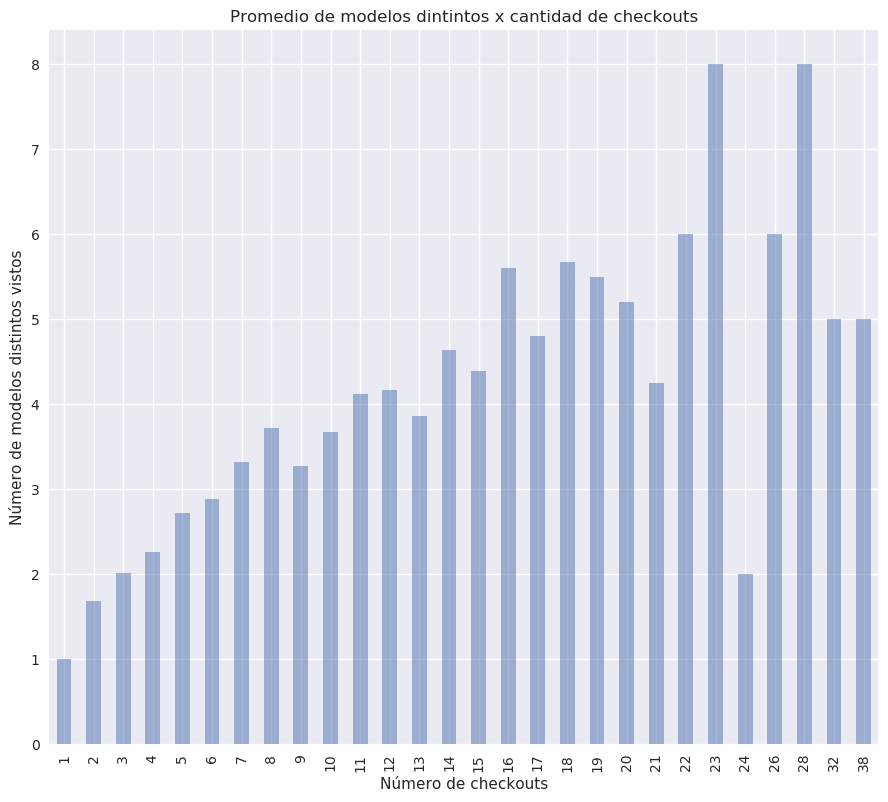

In [132]:
a = checkouts_por_persona.groupby('person').agg({'model':'nunique','checkouts':'count'})
g = a.groupby('checkouts').agg({'model':'mean'}).plot(kind='bar',alpha=0.5)
#a.sort_values(by=['checkouts','model'], ascending = [False,False]).iloc[:100].plot(kind='line',alpha=0.5)
a.loc[a['checkouts']==24]
g.set_title('Promedio de modelos dintintos x cantidad de checkouts')
g.set_xlabel('Número de checkouts')
g.set_ylabel('Número de modelos distintos vistos')
g.legend('')

#### Hago un analisis de las marcas que mas se aparecen en funcion de la cantidad de checkouts que hizo cada cliente

Text(0,0.5,'Cantidad de apariciones')

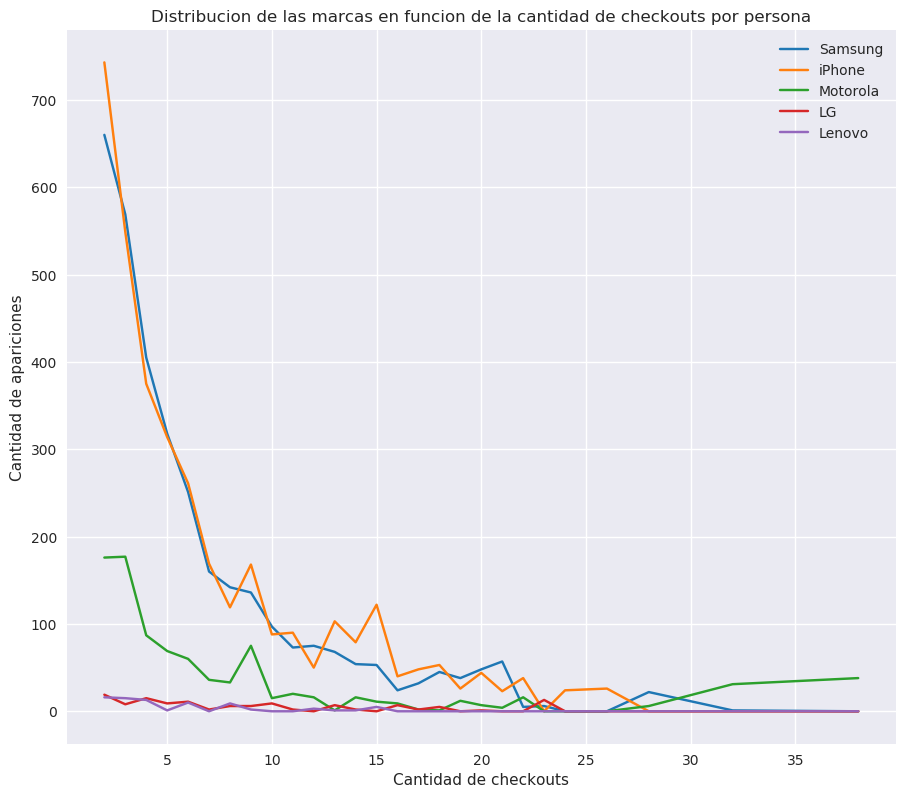

In [133]:
multiples = cantidad_de_checkouts_por_persona.loc[cantidad_de_checkouts_por_persona['checkouts']>1]

my_colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#bcbd22", "#17becf"]  
g = multiples.groupby('checkouts').agg({'Samsung':sum,'iPhone':sum,'Motorola':sum,'LG':sum,'Lenovo':sum,\
        'Sony':sum,'Quantum':sum,'iPad':sum,'Asus':sum}).iloc[:,:5].plot(kind='line',color = my_colors)
g.set_title('Distribucion de las marcas en funcion de la cantidad de checkouts por persona')
g.set_xlabel('Cantidad de checkouts')
g.set_ylabel('Cantidad de apariciones')


#### Hago un analisis de los productos visitados


In [134]:
productos_visitados = df.loc[df['event']=='viewed product',['timestamp','person','sku','model','condition']]


In [135]:
productos_visitados = df.loc[df['event']=='viewed product',['person','sku','model','condition']]
productos_visitados['visita'] = 1
cant_productos_visitados = productos_visitados.groupby('person').agg({'visita':'count'})['visita'].value_counts()


Text(0.5,0,'Cantidad de productos visitados')

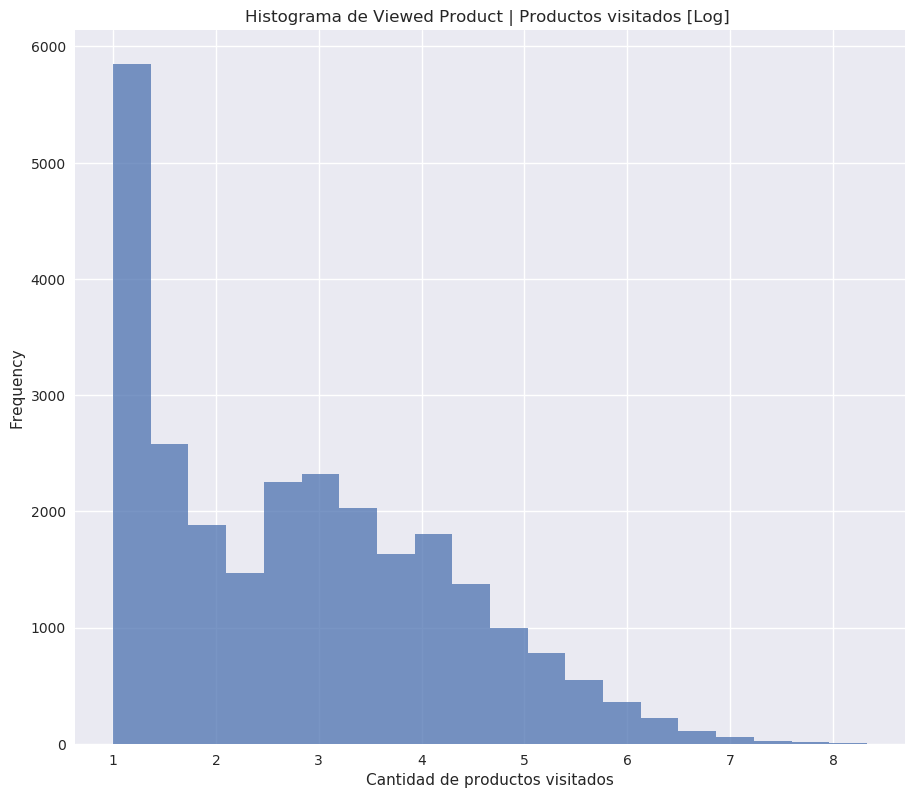

In [136]:
cant_productos_visitados = productos_visitados.groupby('person').agg({'visita':'count'})
g = cant_productos_visitados ['visita']\
    .transform(lambda x: np.log(x)+1 ).plot('hist',alpha=0.75, bins= 20)
g.set_title('Histograma de Viewed Product | Productos visitados [Log] ')
g.set_xlabel('Cantidad de productos visitados')

Text(0.5,1,'Frecuencia de Checkouts x Producto Visitado [Log]')

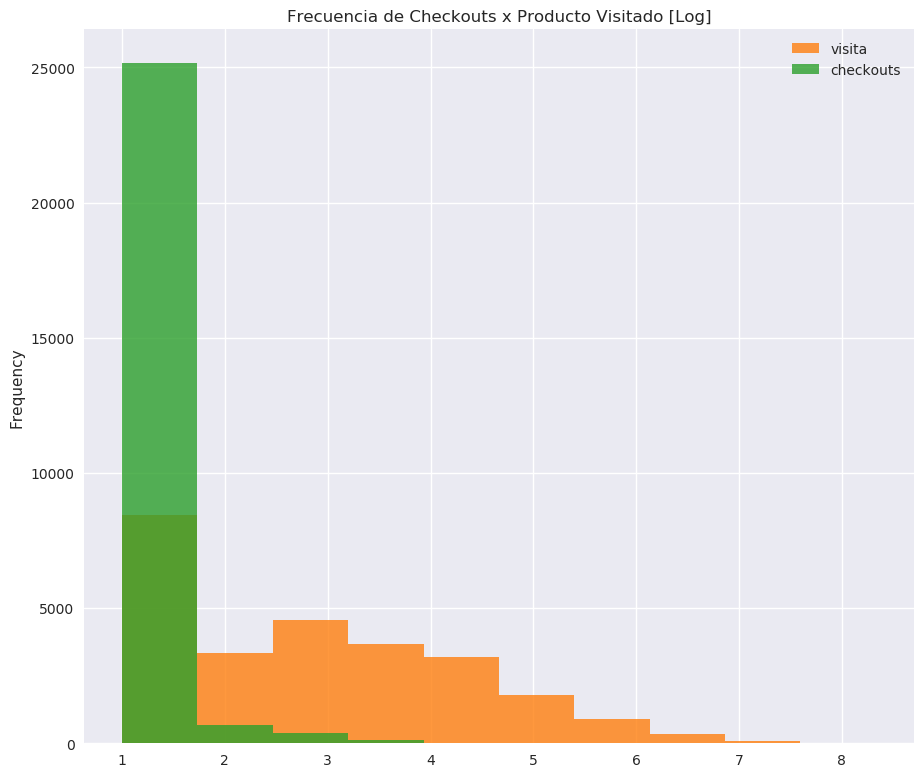

In [137]:
merged = pd.merge(cant_productos_visitados, cantidad_de_checkouts_por_persona, on='person', how='left')
# Estamos sacando aquellas personas que fueron directo al checkout (mediante publicidad) sin observar productos

g = merged[["visita","checkouts"]].transform(lambda x: np.log(x)+1 ).plot(kind='hist',alpha=0.80,bins = 10, color =["#ff7f0e","#2ca02c"])
#merged[["checkouts","visita"]].plot(kind='bar', stacked=True)
g.set_title('Frecuencia de Checkouts x Producto Visitado [Log]')